Meghana Kambhampati

MXK190048

Text Classification

This notebook uses a data set and uses it to implement text classifications. First, a graph of the class distributions is made. Then a sequential model is created. Different architectures like RNN and CNN are evaluated on the test data. After that, embedding approaches are taken on the data. 

In [1]:
import pandas as pd
import seaborn as sb
from sklearn import datasets
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**Import data set**

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Emotion_final.csv to Emotion_final.csv


In [3]:
# load data set
df = pd.read_csv(io.StringIO(uploaded['Emotion_final.csv'].decode('utf-8')), header=0, encoding='latin-1')

**Divide into Train and Test Sets**

In [4]:
# divide into train and test sets
np.random.seed(1234)
i = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]
print("train data size: ", train.shape)
print("test data size: ", test.shape)

train data size:  (17171, 2)
test data size:  (4288, 2)


**Graph of Class Distributions**

The class distribution graph will be made with Seaborn, a Python package used for data display. The graph will show how each piece of data is categorized in the data set. Each class represents an emotion: "happiness," "sadness," "anger," "love," "surprise," and "fear."

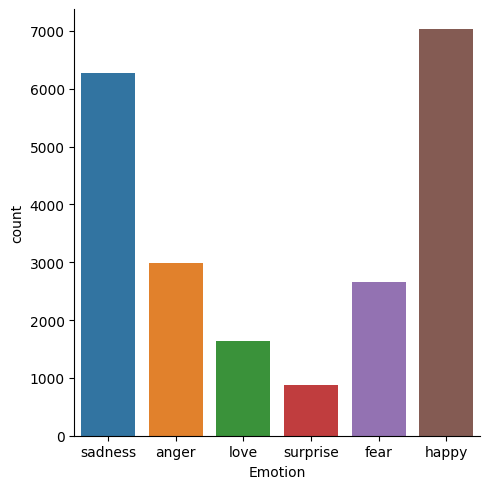

In [5]:
# class distribution
X = df.Text
y = df.Emotion

df = pd.DataFrame(X, columns=df.Text)
df_y = pd.DataFrame(y, columns=['Emotion'])

# create categorical graph
sb.catplot(x="Emotion", kind='count', data=df_y)

The graph shows that there is an unequal distribution of emotions based on the given pieces of text. "Happy" has the most instances, while "surprise" has the least.

This model should be able to predict what emotion a (small) piece of text is expressing.

**Sequential Model**

This is often used as a first, general approach to a deep learning problem. It is made up of a stack of layers with one input and one output tensor. 

In [6]:
num_labels = 6
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train.Text)

x_train = tokenizer.texts_to_matrix(train.Text, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test.Text, mode='tfidf')

encoder = LabelEncoder()
encoder.fit(train.Emotion)
y_train = encoder.transform(train.Emotion)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_labels)
y_test = encoder.transform(test.Emotion)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_labels)

print("train shapes:", x_train.shape, y_train.shape)
print("test shapes:", x_test.shape, y_test.shape)

train shapes: (17171, 10000) (17171, 6)
test shapes: (4288, 10000) (4288, 6)


In [7]:
# to avoid overfitting
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=4,    
    restore_best_weights=True,
)

In [8]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [9]:
model = models.Sequential()
model.add(layers.Dense(46, input_dim=x_train.shape[1], activation='relu'))
model.add(layers.Dense(num_labels, activation='softmax'))

model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["acc"]
)
history=model.fit(x_train, 
          y_train, 
          batch_size=128, 
          callbacks=[early_stopping], 
          validation_data=(x_val, y_val))

135/135 [==============================] - 4s 24ms/step - loss: 1.0449 - acc: 0.6686 - val_loss: 0.2641 - val_acc: 0.9490


In [10]:
score = model.evaluate(x_test, y_test)
print('Accuracy: ', score[1])
print(score)

134/134 [==============================] - 0s 3ms/step - loss: 0.4981 - acc: 0.8601
Accuracy:  0.8600746393203735
[0.49805355072021484, 0.8600746393203735]


The accuracy of this model peaked at around 85-86%, which is a little disappointing. In general, choosing a smaller batch size and larger unit size and vocab size improved performance. I had to adjust each variable separately to find the optimal values. The sequential model 

**Recurrent Neural Network (RNN)**

RNNs are usually used with text data (or time series data), which matches this data set well. They have states or meomory that allow for the processing of sequences. This creates hidden states within steps. Keras has three RNN types: SimpleRNN, LSTM, and GRU. Here, I use SimpleRNN.

In [11]:
max_features = 21460

model2 = models.Sequential()
model2.add(layers.Embedding(input_dim=max_features, output_dim=32))
model2.add(layers.SimpleRNN(32)) 
model2.add(layers.Dense(6, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          686720    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 688,998
Trainable params: 688,998
Non-trainable params: 0
_________________________________________________________________


In [12]:
model2.compile(
    loss="categorical_crossentropy", 
    optimizer="rmsprop", 
    metrics=['accuracy']
)

In [13]:
history = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
15/15 [==============================] - 312s 21s/step - loss: 1.6086 - accuracy: 0.3159 - val_loss: 1.5976 - val_accuracy: 0.3414
Epoch 2/10
15/15 [==============================] - 346s 23s/step - loss: 1.5945 - accuracy: 0.3159 - val_loss: 1.5937 - val_accuracy: 0.3415
Epoch 3/10
15/15 [==============================] - 353s 24s/step - loss: 1.5968 - accuracy: 0.3159 - val_loss: 1.5887 - val_accuracy: 0.2879
Epoch 4/10
15/15 [==============================] - 318s 21s/step - loss: 1.5937 - accuracy: 0.3069 - val_loss: 1.5834 - val_accuracy: 0.3415
Epoch 5/10
15/15 [==============================] - 353s 24s/step - loss: 1.5941 - accuracy: 0.3159 - val_loss: 1.5803 - val_accuracy: 0.3415
Epoch 6/10
15/15 [==============================] - 366s 24s/step - loss: 1.5936 - accuracy: 0.3156 - val_loss: 1.5797 - val_accuracy: 0.3415
Epoch 7/10
15/15 [==============================] - 357s 24s/step - loss: 1.5938 - accuracy: 0.3159 - val_loss: 1.5843 - val_accuracy: 0.3415
Epoch 

This took a long time to train, much longer than the sequential model.

In [14]:
score = model2.evaluate(x_test, y_test)
print('Accuracy: ', score[1])
print(score)

134/134 [==============================] - 68s 510ms/step - loss: 1.6135 - accuracy: 0.2887
Accuracy:  0.28871268033981323
[1.6135189533233643, 0.28871268033981323]


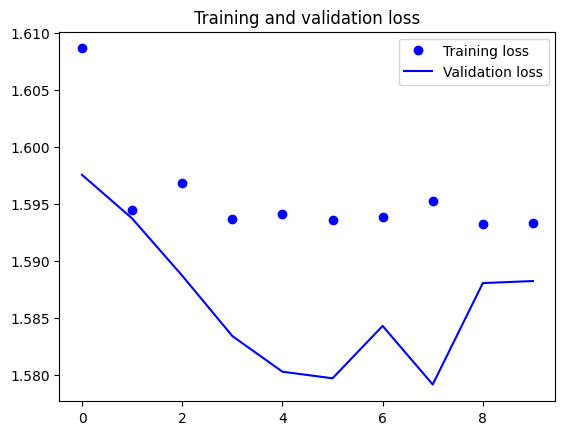

In [15]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The accuracy on this attempt was very low. The training also took a surprisingly long time. The validation loss is all over the place here. 

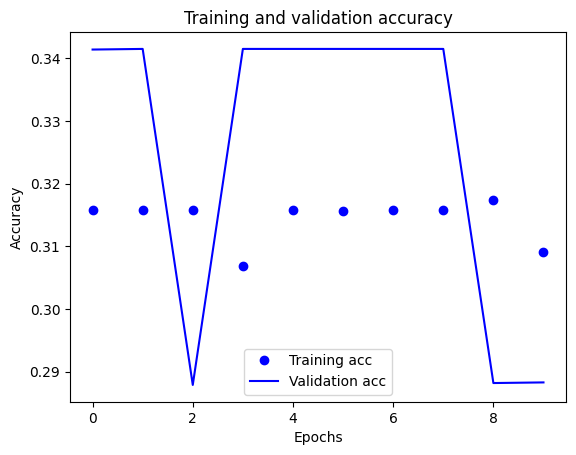

In [16]:
plt.clf()   

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The validation accuracy is confusing to say the least. The accuracy did not improve over the course of the ten epochs for some reason. The validation accuracy is confusing to say the least. The accuracy did not improve over the course of the ten epochs for some reason. 

Implementing an early stop mechanism may help.

In [17]:
history = model2.fit(partial_x_train,
                    partial_y_train,
                    callbacks=[early_stopping],
                    batch_size=512,
                    validation_data=(x_val, y_val))

15/15 [==============================] - 366s 25s/step - loss: 1.5947 - accuracy: 0.3039 - val_loss: 1.5794 - val_accuracy: 0.3415


In [18]:
score = model2.evaluate(x_test, y_test)
print('Accuracy: ', score[1])
print(score)

134/134 [==============================] - 64s 477ms/step - loss: 1.6208 - accuracy: 0.3146
Accuracy:  0.3145988881587982
[1.620800256729126, 0.3145988881587982]


Including early stopping does not offer any improvement at all. :(

**Convolutional Neural Network (CNN)**

CNNs are also often used with text data. This model learns in small windows, allowing it to recognize spatial hierarchies. Padding corrects tensor shapes and maxpooling reduces the number of parameters to learn.

In [19]:
model3 = models.Sequential()
model3.add(layers.Embedding(max_features, 128, input_length=10000)) 
model3.add(layers.Conv1D(32, 7, activation='relu')) 
model3.add(layers.MaxPooling1D(4)) 
model3.add(layers.Conv1D(32, 7, activation='relu')) 
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(6))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 128)        2746880   
                                                                 
 conv1d (Conv1D)             (None, 9994, 32)          28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2498, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2492, 32)          7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 6)                

In [20]:
model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/10
57/57 [==============================] - 739s 13s/step - loss: 6.3976 - accuracy: 0.3159 - val_loss: 6.0411 - val_accuracy: 0.3415
Epoch 2/10
57/57 [==============================] - 701s 12s/step - loss: 6.2845 - accuracy: 0.3159 - val_loss: 6.0411 - val_accuracy: 0.3415
Epoch 3/10
57/57 [==============================] - 748s 13s/step - loss: 6.2845 - accuracy: 0.3159 - val_loss: 6.0411 - val_accuracy: 0.3415
Epoch 4/10
57/57 [==============================] - 738s 13s/step - loss: 6.2845 - accuracy: 0.3159 - val_loss: 6.0411 - val_accuracy: 0.3415
Epoch 5/10
57/57 [==============================] - 737s 13s/step - loss: 6.2845 - accuracy: 0.3159 - val_loss: 6.0411 - val_accuracy: 0.3415
Epoch 6/10
57/57 [==============================] - 742s 13s/step - loss: 6.2845 - accuracy: 0.3159 - val_loss: 6.0411 - val_accuracy: 0.3415
Epoch 7/10
57/57 [==============================] - 728s 13s/step - loss: 6.2845 - accuracy: 0.3159 - val_loss: 6.0411 - val_accuracy: 0.3415
Epoch 

In [21]:
score = model3.evaluate(x_test, y_test)
print('Accuracy: ', score[1])
print(score)

134/134 [==============================] - 67s 503ms/step - loss: 6.4502 - accuracy: 0.3146
Accuracy:  0.3145988881587982
[6.450246810913086, 0.3145988881587982]


**Embeddings**

There are many different embedding types. Context-free embeddings create representations for specific words in the vocabulary. Contextual embeddings, on the other hand, use the context of words. 

In [24]:
model4 = models.Sequential()
model4.add(layers.Embedding(max_features, 8, input_length=10000))
model4.add(layers.Flatten())
model4.add(layers.Dense(16, activation='relu'))
model4.add(layers.Dense(6, activation='sigmoid'))

model4.compile(optimizer='rmsprop', 
               loss='categorical_crossentropy', 
               metrics=['acc'])
model4.summary()

history = model4.fit(x_train,
                     y_train, 
                     epochs=10, 
                     batch_size=32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10000, 8)          171680    
                                                                 
 flatten (Flatten)           (None, 80000)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                1280016   
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
Total params: 1,451,798
Trainable params: 1,451,798
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
537/537 [==============================] - 20s 36ms/step - loss: 1.7099 - acc: 0.3226
Epoch 2/10
537/537 [==============================] - 19s 34ms/step - loss: 1.6

In [25]:
score = model3.evaluate(x_test, y_test)
print('Accuracy: ', score[1])
print(score)

134/134 [==============================] - 68s 508ms/step - loss: 6.4502 - accuracy: 0.3146
Accuracy:  0.3145988881587982
[6.450246810913086, 0.3145988881587982]


Overall, these deep learning techniques did a poor job of accurately predicting the emotion of a piece of text. Not only were the accuracy and loss very bad, but the model training took way too long, regardless of what settings were changed. Varying the number of epochs showed no improvement. The sequential model showed the best results while everything else was not good. Further testing could include different preprocessing, embeddings, and model layers to try to improve results.